In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Biassay model

Bioassay model. In this exercise, you will use a dose-response relation model that is used in Section 3.7 of the course book and in the chapter reading instructions. The used likelihood is the same, but instead of uniform priors, we will use a bivariate normal distribution as the joint prior distribution of the parameters α and β.

a) In the prior distribution for (α, β), the marginal distributions are α ∼ N (0, 2^2) and β ∼ N (10, 10^2), and the correlation between them is corr(α, β) = 0.6. Report the mean (vector of two values) and covariance (two by two matrix) of the bivariate normal distribution. 

Hint! The mean and covariance of the bivariate normal distribution are a length 2 vector and a 2 × 2 matrix. The elements of the covariance matrix can be computed using the relation of correlation and covariance.

In [205]:
#prior
x = np.linspace(-10, 20, 1000).reshape(-1)
x.shape

(1000,)

In [202]:
#mean vector is 
means=[0, 10]

In [203]:
cov=0.6*(2**2)*(10**2)
cov_mat=[[2**2, 0.6*10*2],
        [0.6*2*10, 10**2]]
cov_mat

[[4, 12.0], [12.0, 100]]

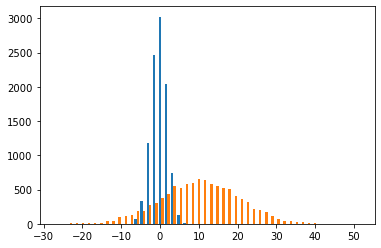

In [213]:
y_samp=stats.multivariate_normal.rvs(mean=[0, 10], cov=cov_mat, size=10000)
_=plt.hist(y_samp, bins=50)

b) You are given 4000 independent draws from the posterior distribution of the model. Load the draws with data ("bioassay_posterior"). Report the mean as well as 5 % and 95 % quantiles separately for both α and β. Report also the Monte Carlo standard errors (MCSEs) for the mean and quantile estimates. Report as many digits for the mean and quantiles as the MCSEs allow. In other words, leave out digits where MCSE is nonzero (Example: if posterior mean is 2.345678 and MCSE is 0.0012345, report two digits after the decimal sign, taking into account the usual rounding rule, so you would report 2.35. Further digits do not contain useful information due to the Monte Carlo uncertainty.). Explain in words what does Monte Carlo standard error mean and how you decided the number of digits to show. 

Note! The answer is graded as correct only if the number of digits reported is correct! The number of signicant digits can be different for the mean and quantile estimates. In some other cases, the number of digits reported can be less than MCSE allows for practical reasons.

Hint! Quantiles can be computed with the quantile function. With S draws, the MCSE for E[θ] is √Var[θ]/S. MCSE for the quantile estimates can be computed with the mcse_quantile function from the aaltobda package.

In [31]:
df_posterior=pd.read_csv('data/bioassay_posterior.txt',sep='\t', header=None)
df_posterior.columns=['alpha', 'beta']
df_posterior.shape

(4000, 2)

In [32]:
df_posterior.head()

,alpha,beta
0,-0.020506,10.032841
1,1.217385,4.504546
2,3.048294,16.239424
3,1.322728,4.924268
4,1.362748,12.880561


In [59]:
df_posterior.mean(axis=0).round(1)

alpha     1.0
beta     10.6
dtype: float64

<AxesSubplot:>

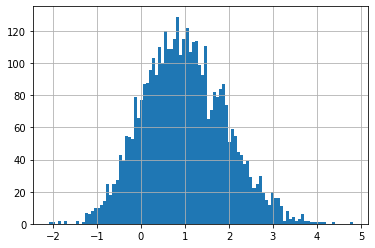

In [44]:
df_posterior.alpha.hist(bins=100)

<AxesSubplot:>

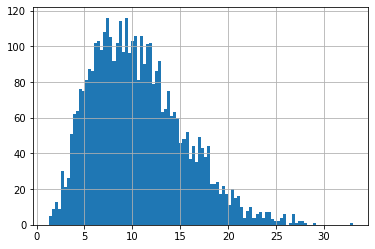

In [45]:
df_posterior.beta.hist(bins=100)

<AxesSubplot:xlabel='alpha', ylabel='beta'>

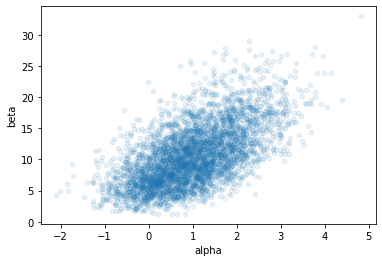

In [49]:
df_posterior.plot.scatter(x='alpha', y='beta', alpha=0.1)

In [56]:
#MCSE for alpha
np.round(np.std(df_posterior.alpha)/np.sqrt(df_posterior.shape[0]), 4)

0.0148

In [58]:
#MCSE for beta
np.round(np.std(df_posterior.beta)/np.sqrt(df_posterior.shape[0]), 4)

0.0756

In [190]:
def mcse_quantile(x, q):
    #source: https://github.com/avehtari/BDA_course_Aalto/blob/master/rpackage/R/mcse_quantile.R
    s=len(x)
    # these are the same as pnorm(c(-1,1)) and these are passed through
    # a non-linear mapping
    p = [0.1586553, 0.8413447]
    a = stats.beta.ppf(p, s * q + 1, s * (1 - q) + 1)
    sx = np.sort(x.values.reshape(-1))
    th1=sx[int(max(np.floor(a[0] * s)-1, 1))]
    th2 = sx[int(min(np.ceil(a[1] * s)-1, s))]
    # if the mapping from p to th would be linear, this would give
    # exact MCSE, but even with non-linear mapping this is a good approximation
    mcse = (th2 - th1) / 2
    return mcse

In [191]:
mcse_quantile(df_posterior.alpha, 0.05)

0.026004115975011483

In [192]:
mcse_quantile(df_posterior.alpha, 0.95)

0.04206341679185521

In [193]:
mcse_quantile(df_posterior.beta, 0.05)

0.0704312509185201

In [194]:
mcse_quantile(df_posterior.beta, 0.95)

0.24121288770735028

In [64]:
#quantiles 5%
np.quantile(df_posterior.alpha, 0.05).round(1), np.quantile(df_posterior.beta, 0.05).round(1)

(-0.5, 4.0)

In [195]:
#quantiles 95%
np.quantile(df_posterior.alpha, 0.95).round(1), np.quantile(df_posterior.beta, 0.95).round(0)

(2.6, 19.0)

### Importance sampling. Now we discard our posterior draws and switch to importance sampling.

c) Implement a function for computing the log importance ratios (log importance weights) when the importance sampling target distribution is the posterior distribution, and the proposal distribution is the prior distribution from a). Below is a test example, the functions can also be tested with markmyassignment. Explain in words why it's better to compute log ratios instead of ratios.

- Note! The values below are only a test case. In this c) part, you only need to report the source code of your function, as it will be needed in later parts. 

- Hints! Use the function rmvnorm from the aaltobda package for sampling. Non-log importance ratios are given by equation (10.3) in the course book. The fact that our proposal distribution is the same as the prior distribution makes this task easier. The logarithm of the likelihood can be computed with the bioassaylp function from the aaltobda package. The data required for the likelihood can be loaded with data("bioassay").

alpha <- c(1.896, -3.6, 0.374, 0.964, -3.123, -1.581)

beta <- c(24.76, 20.04, 6.15, 18.65, 8.16, 17.4) 

round(log_importance_weights(alpha, beta),2) 

[1] -8.95 -23.47 -6.02 -8.13 -16.61 -14.57

In [ ]:
#proposal distribution
g=None

#target distribution
q=stats.multivariate_normal.rvs(mean=[0, 10], cov=cov_mat, size=10000)

In [ ]:
def log_importance_weights(alpha, beta):
    w = np.log(q/g)

In [214]:
alpha=[1.896, -3.6, 0.374, 0.964, -3.123, -1.581]
beta=[24.76, 20.04, 6.15, 18.65, 8.16, 17.4]

In [215]:
np.log(alpha)-np.log(beta)

C:\Users\RistoHinno\AppData\Local\Temp\ipykernel_32960\4125278159.py:1: RuntimeWarning: invalid value encountered in log
  np.log(alpha)-np.log(beta)


array([-2.56948304,         nan, -2.79995156, -2.96251013,         nan,
               nan])

In [ ]:
x = np.linspace(-10, 20, 1000)
g = stats.norm.pdf(x, loc=g_mean, scale=g_std)